In [1]:
# ================================================
# 必要なライブラリのインポートと表示設定
# ================================================

# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set()  # Seabornのデフォルトスタイルを有効化（見やすいグラフに）

# データ読み込み
import statsmodels.api as sm

# sktime：グラフ描画ユーティリティ
from sktime.utils.plotting import plot_series

# sktime：予測モデル
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster

# sktime：予測の評価指標
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,
    MeanAbsoluteError,
    mean_absolute_percentage_error,
    mean_absolute_error,
)

# sktime：予測評価・モデル選択
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
)
from sktime.forecasting.model_evaluation import evaluate

# sktime：データ変換（季節調整・トレンド除去・差分など）
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer

# sktime：パイプライン構築
from sktime.forecasting.compose import TransformedTargetForecaster, MultiplexForecaster
from sktime.transformations.compose import OptionalPassthrough

# --------------------------------
# グラフの日本語表記設定
# --------------------------------
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"  # 日本語を「メイリオ」で表示

# --------------------------------
# DataFrame の全角文字（日本語など）の出力を整形
# --------------------------------
pd.set_option("display.unicode.east_asian_width", True)
# これにより、DataFrameを print したときに
# 全角文字がきれいに整列して表示される

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

In [3]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスの作成(PeriodIndex)
date_index = pd.period_range(start="1949-01", periods=len(air_passengers), freq="M")
air_passengers.index = date_index

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

# 結果の確認
print(air_passengers.head(3))

         value
1949-01    112
1949-02    118
1949-03    132


<Axes: >

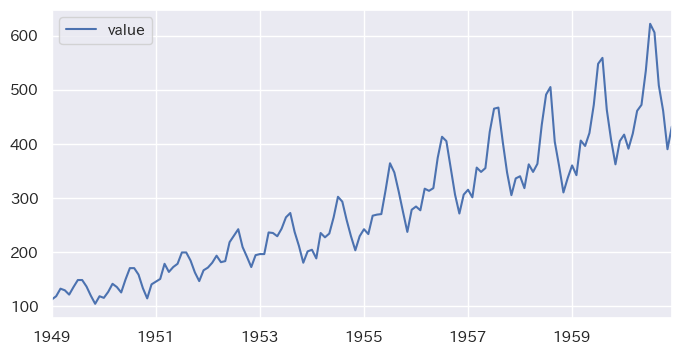

In [4]:
# 参考：素朴にpandasのplot関数を適用

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 折れ線グラフを描く
air_passengers.plot(ax=ax)

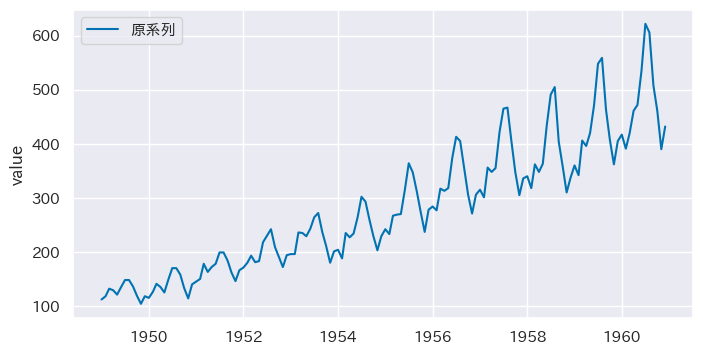

In [5]:
# 参考：sktimeのplot_series関数を利用

# ==============================
# 飛行機乗客数データを折れ線グラフで可視化
# ==============================

# sktimeの便利な可視化関数plot_seriesを利用して描画
# labels：凡例に表示するラベル
# markers：データ点にマーカーを付ける（''で非表示）
fig, ax = plot_series(air_passengers, labels=["原系列"], markers=[""])

# グラフサイズの指定（横8インチ × 縦4インチ）
fig.set_size_inches(8, 4)

# axはmatplotlibのAxesオブジェクトで、
# さらにタイトルや軸ラベルを追加することも可能
# 例: ax.set_title('AirPassengers データの時系列')

In [6]:
# ===============================================
# 訓練データとテストデータへの分割
# ===============================================
# temporal_train_test_split：
#   時系列データを「過去（train）」と「未来（test）」に分割する関数。
#   ランダムではなく、**時間順**に分ける点が重要。
#
# test_size=36：
#   36か月（＝3年分）をテストデータとして確保。
#   残りは訓練データとしてモデルの学習に使用する。
#
# test.index：
#   分割後のテストデータのインデックス（日付）を確認。
# ===============================================

train, test = temporal_train_test_split(air_passengers, test_size=36)
test.index

PeriodIndex(['1958-01', '1958-02', '1958-03', '1958-04', '1958-05', '1958-06',
             '1958-07', '1958-08', '1958-09', '1958-10', '1958-11', '1958-12',
             '1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]')

In [7]:
# ===============================================
# 予測期間（Forecasting Horizon）の設定
# ===============================================
# fh（Forecasting Horizon）とは：
#   何ステップ先まで予測するかを指定するベクトル。
#   sktimeの予測器（Forecaster）は、fhに基づいて未来の期間を決定する。
#
# np.arange(1, len(test) + 1)：
#   テストデータの長さと同じだけ「1, 2, 3, ...」という
#   予測ステップ番号を生成。
#   ここでは、テストデータが36か月分なので fh = [1, 2, ..., 36]
#   となり、「36か月先まで予測する」という意味になる。
# ===============================================

fh = np.arange(1, len(test) + 1)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36])